In [7]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

import crocosi.postp as pp
import dask.dataframe as dd
import pandas as pd

import hvplot.pandas
import hvplot.dask
import pandas as pd
from glob import glob
import xarray as xr

In [2]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:54804 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [25]:
#from u and v grids to rho grid
#Return Dataset with u,v and U in rho grid:

def U2rho(var_u, var_v, intert):
    if var_u.ndim<3:
        var_rho = U2rho_2d(var_u, var_v, intert)
    else:
        var_rho = U2rho_3d(var_u, var_v, intert)

    return var_rho


def U2rho_2d(var_u, var_v, intert):
    [Mp,L]=var_u.shape
    Lp=L+1
    Lm=L-1
    M=var_v.shape[0]
    Mm=M-1
    var_rho=xr.Dataset({'u': (['y_rho','x_rho'],np.zeros((Mp,Lp))), 'v': (['y_rho','x_rho'],np.zeros((Mp,Lp))),
                        'U': (['y_rho','x_rho'],np.zeros((Mp,Lp)))},coords={'y_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.sel(time=intert,method='nearest').coords['x_rho'].values})

#r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,1:L]=0.5*(var_u[:,0:Lm]+var_u[:,1:L])
    var_rho.u[:,0]=var_rho.u[:,1]
    var_rho.u[:,Lp-1]=var_rho.u[:,L-1]
    var_rho.v[1:M,:]=0.5*(var_v[0:Mm,:]+var_v[1:M,:])
    var_rho.v[0,:]=var_rho.v[1,:]
    var_rho.v[Mp-1,:]=var_rho.v[M-1,:]
    var_rho.U.values=np.sqrt(var_rho.u**2+var_rho.v**2).values
    return var_rho


def U2rho_3d(var_u,var_v,intert):
    var_u = var_u.sel(time=slice(intert[0],intert[1]))
    [N,Mp,L]=var_u.shape
    M=var_v.shape[1]
    Lp=L+1
    Lm=L-1
    Mm=M-1
    var_rho=xr.Dataset({'u': (['time','y_rho','x_rho'],np.zeros((N,Mp,Lp))), 'v': (['time','y_rho','x_rho'],np.zeros((N,Mp,Lp))),
                        'U': (['time','y_rho','x_rho'],np.zeros((N,Mp,Lp)))},coords={'time' : r['surf'].ssh.sel(time=slice(intert[0],intert[1])).coords['time'].values,
                                                                              'y_rho' : r['surf'].ssh.coords['y_rho'].values,
                                                                          'x_rho' : r['surf'].ssh.coords['x_rho'].values})

    #r['surf'].ssh.sel(time=1550,method='nearest').copy()#np.zeros((Mp,Lp))
    var_rho.u[:,:,1:L]=0.5*(var_u[:,:,0:Lm]+var_u[:,:,1:L])
    var_rho.u[:,:,0]=var_rho.u[:,:,1]
    var_rho.u[:,:,Lp-1]=var_rho.u[:,:,L-1]
    var_rho.v[:,1:M,:]=0.5*(var_v[:,0:Mm,:]+var_v[:,1:M,:])
    var_rho.v[:,0,:]=var_rho.v[:,1,:]
    var_rho.v[:,Mp-1,:]=var_rho.v[:,M-1,:]
    var_rho.U.values=np.sqrt(var_rho.u**2+var_rho.v**2).values
    return var_rho





In [4]:
root_path = '/Users/zcaspar/'
#run = 'jet_cfg1_wp9_4km_0a2000j/'
run = 'jet_cfg1_wp75_4km_1500a2000j_floats_lev50_itide/'
#file='t1/file_his_00010101-00010125.nc'
#File='t1'
gparams = {'f0': 1.0313e-4, 'beta': 1.6186e-11}
r = pp.CROCOrun(root_path+run, prefix='file_', open_nc=['surf'], grid_params=gparams)

In [5]:
# Vitesses sur intervalle de temps voulu (ou 1 tps donné) sur grille rho:
var_u = r['surf'].u[:,0,:,:].sel(time=1550,method='nearest')
var_v = r['surf'].v[:,0,:,:].sel(time=1550,method='nearest')
intert=1550

In [26]:
U_rho = U2rho(var_u,var_v,intert)

In [27]:
U_rho.U.values=np.sqrt(U_rho.u**2+U_rho.v**2).values

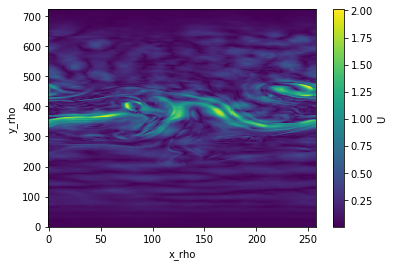

In [29]:
U_rho.U.plot()